In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from moztelemetry.dataset import Dataset

%matplotlib inline

### Basics

We will use the Dataset API to fetch data.  Documentation can be found at: https://python-moztelemetry.readthedocs.io/en/stable/api.html#dataset

The goal of this example is to plot the startup distribution for each OS. Let's see how many parallel workers we have at our disposal:

In [2]:
sc.defaultParallelism

32

We can look at the schema of the dataset we are interested in:

In [3]:
Dataset.from_source('telemetry').schema

[u'submissionDate',
 u'sourceName',
 u'sourceVersion',
 u'docType',
 u'appName',
 u'appUpdateChannel',
 u'appVersion',
 u'appBuildId']

Let's create a Dataset of Telemetry submissions for a given submission date:

In [4]:
pings_dataset = (
    Dataset.from_source('telemetry')
    .where(docType='main')
    #.where(appBuildId='20180721100146')
    .where(submissionDate=lambda x: int(x) == 20180927 or int(x) == 20180926 or int(x) == 20180928 or int(x) == 20180929)
    .where(appUpdateChannel="nightly")
)

Select only the properties we need and then take a 10% sample:

In [7]:
pings = (
    pings_dataset
    .select(
        'clientId',
        buildId='application.buildId',
        content_paint='payload.processes.content.histograms.CONTENT_PAINT_TIME.values',
        content_paint_phase='payload.processes.content.keyedHistograms.CONTENT_LARGE_PAINT_PHASE_WEIGHT',
        tab_switch='payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS.values',
        tab_switch_sum='payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS.sum',
        frame_time='payload.processes.gpu.histograms.CONTENT_FRAME_TIME.values',
        frame_time_sum='payload.processes.gpu.histograms.CONTENT_FRAME_TIME.sum',
        composite_time='payload.processes.gpu.histograms.COMPOSITE_TIME',
        checkerboardin='payload.processes.gpu.histograms.CHECKERBOARD_SEVERITY.values',
        experiments='environment.experiments',
        settings='environment.settings',
        osName='environment.system.os.name',
        gfx='environment.system.gfx')
    .records(sc, sample=1.)
)

fetching 26054.85692MB in 94826 files...


In [8]:
#pings = (
#    pings_dataset
#    .records(sc, sample=0.01)
#)
#pings.take(1)

In [9]:
pings = pings.filter(lambda p: "experiments" in p and p["experiments"]).filter(lambda p: "prefflip-webrender-v1-2-1492568" in p["experiments"])

In [ ]:
pings = pings.cache()

In [ ]:
pings.take(4)

In [ ]:
# We add two extra steps. The first rewrites the ping to have some
# information more easily accessible (like the primary adapter),
# and the second step removes any pings that don't have adapter
# information.
def rewrite_ping(p):
    adapters = p.get('gfx', None).get('adapters', None)
    if not adapters:
        return None
    adapter = adapters[0]
            
    p['adapter'] = adapter
            
    # Convert the version to a tuple of integers.
    #if 'driverVersion' in adapter:
    #    p['driverVersion'] = [int(n) for n in adapter['driverVersion'].split('.') if n.isdigit()]
    return p

def filter_ping(p):
    return 'adapter' in p
rpings = pings.map(rewrite_ping).filter(filter_ping)
rpings = rpings.cache()
rpings.count()

To prevent pseudoreplication, let's consider only a single submission for each client. As this step requires a distributed shuffle, it should always be run only after extracting the attributes of interest with *Dataset.select()*.

In [ ]:
# we don't want to ignore separate pings from the same users
#subset = (
#    rpings
#    .map(lambda p: (p['clientId'], p))
#    .reduceByKey(lambda p1, p2: p1)
#    .map(lambda p: p[1])
#)

Caching is fundamental as it allows for an iterative, real-time development workflow:

In [ ]:
cached = rpings

In [ ]:
#cached = subset.cache()

How many pings are we looking at?

In [ ]:
cached.count()

In [ ]:
cached.filter(lambda p: p['checkerboardin']).count()

In [14]:
cached = cached.filter(lambda p: "features" in p["gfx"])
cached = cached.filter(lambda p: "wrQualified" in p["gfx"]["features"])
cached.count()

37028

In [15]:
wrQualified = cached.filter(lambda p: p["gfx"]["features"]["wrQualified"]["status"] == "available" )
wrQualified.count()
wrQualified = wrQualified.filter(lambda p: len(p["gfx"]["monitors"]) == 1 and p["gfx"]["monitors"][0]["refreshRate"] == 60)

In [16]:
wrQualified.filter(lambda p: "experiments" in p and p["experiments"]).map(lambda p: p["experiments"]).take(5)

[{u'prefflip-webrender-v1-2-1492568': {u'branch': u'disabled',
   u'type': u'normandy-exp'}},
 {u'prefflip-webrender-v1-2-1492568': {u'branch': u'enabled',
   u'type': u'normandy-exp'}},
 {u'prefflip-webrender-v1-2-1492568': {u'branch': u'disabled',
   u'type': u'normandy-exp'}},
 {u'prefflip-webrender-v1-2-1492568': {u'branch': u'disabled',
   u'type': u'normandy-exp'}},
 {u'prefflip-webrender-v1-2-1492568': {u'branch': u'disabled',
   u'type': u'normandy-exp'}}]

In [17]:
wrExperiment = cached.filter(lambda p: "experiments" in p and p["experiments"]).filter(lambda p: "prefflip-webrender-v1-2-1492568" in p["experiments"])
wrExperiment.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

defaultdict(int, {u'basic': 1304, u'd3d11': 12482, u'webrender': 23242})

In [18]:
wrExperiment = wrExperiment.filter(lambda p: p["gfx"]["features"]["wrQualified"]["status"] == "available")
wrExperiment = wrExperiment.filter(lambda p: len(p["gfx"]["monitors"]) == 1 and p["gfx"]["monitors"][0]["refreshRate"] == 60)

In [19]:
wrExperiment.map(lambda p: p["experiments"]["prefflip-webrender-v1-2-1492568"]["branch"]).countByValue()

defaultdict(int, {u'disabled': 7915, u'enabled': 8761})

In [20]:
treatment = wrExperiment.filter(lambda p: p["experiments"]["prefflip-webrender-v1-2-1492568"]["branch"] == "enabled")
control = wrExperiment.filter(lambda p: p["experiments"]["prefflip-webrender-v1-2-1492568"]["branch"] == "disabled")
(treatment.count(), control.count())

(8761, 7915)

In [21]:
#wrt = qTreatment.filter(lambda p: p["gfx"]["features"]["compositor"] == 'd3d11').filter(lambda p: 'webrender' in p["gfx"]["features"])
#wrt.map(lambda p: p["gfx"]["features"]["webrender"]["status"]).countByValue()
#wrt.count()

In [22]:
cached.filter(lambda p: p['checkerboardin']).map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

defaultdict(int, {u'basic': 457, u'd3d11': 5979, u'webrender': 10944})

In [23]:
checked = cached.filter(lambda p: p['checkerboardin']).filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
checked.map(lambda p: p["gfx"]["D2DEnabled"]).countByValue()

defaultdict(int, {False: 1592, True: 9352})

In [24]:
treatment.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()

defaultdict(int, {u'basic': 261, u'd3d11': 167, u'webrender': 8333})

In [25]:
(treatment
 #.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
.filter(lambda p: 'gfx.webrender.all.qualified' in p['settings']['userPrefs'])
 .map(lambda p: p['settings']['userPrefs']['gfx.webrender.all.qualified']).countByValue()
)

defaultdict(int, {True: 6552})

In [26]:
(control.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender").map(lambda p: p['buildId']).countByValue())

defaultdict(int,
            {u'20180913100107': 30,
             u'20180914100156': 7,
             u'20180914220208': 4,
             u'20180915115425': 3,
             u'20180915220059': 8,
             u'20180916100118': 2,
             u'20180916220033': 15,
             u'20180917100342': 8,
             u'20180918075510': 50,
             u'20180919003800': 17,
             u'20180919123806': 2,
             u'20180919220108': 4,
             u'20180920100522': 13,
             u'20180920220102': 8,
             u'20180921100113': 14,
             u'20180921220134': 8,
             u'20180922100157': 19,
             u'20180922220057': 47,
             u'20180923100316': 43,
             u'20180923220427': 29,
             u'20180924100354': 97,
             u'20180924220042': 26,
             u'20180925100100': 134,
             u'20180925220052': 276,
             u'20180926142037': 7,
             u'20180926142055': 137,
             u'20180926220146': 157,
             u'201

In [27]:
(treatment
 #.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
.filter(lambda p: 'gfx.webrender.all.qualified' not in p['settings']['userPrefs'])
 # .map(lambda p: p["gfx"]["features"]["wrQualified"]['status']).countByValue()
 #.filter(lambda p: int(p['buildId']) > 20180913100107  )
 #.map(lambda p: p['experiments']).take(8)
 #.map(lambda p: int(p['buildId'])).countByValue()

 #.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()
 #.filter(lambda p: p["gfx"]["features"]["compositor"] =='d3d11')

#.map(lambda p: (p['buildId'], p['adapter']['description'], p['settings']['userPrefs'])).take(9)
.count()
)*1./treatment.count()

0.25214016664764294

In [28]:
control = control.filter(lambda p: p["gfx"]["features"]["compositor"] == "d3d11")

In [144]:
wrQualified.take(1)

[{'adapter': {u'GPUActive': True,
   u'RAM': 4096,
   u'description': u'NVIDIA GeForce GTX 1050 Ti',
   u'deviceID': u'0x1c82',
   u'driver': u'C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumdx.dll,C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumdx.dll,C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumdx.dll,C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumdx.dll C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumd.dll,C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumd.dll,C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumd.dll,C:\\Windows\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_cad5fc8f5ca41c15\\nvldumd.dll',
   u'driverDate': u'9-18-2018',
   u'drive

In [25]:
wrEnabled = treatment.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender")
wrDisabled = control.filter(lambda p: p["gfx"]["features"]["compositor"] == "d3d11")
wrEnabled.count(), wrDisabled.count()

(8333, 5712)

In [25]:
def aggregateHist(p, hist):
    aggregated = p.map(hist).map(lambda p: pd.Series(p)).reduce(aggregate_series)
    aggregated.index = [int(i) for i in aggregated.index]
    aggregated = aggregated.sort_index()
    return aggregated

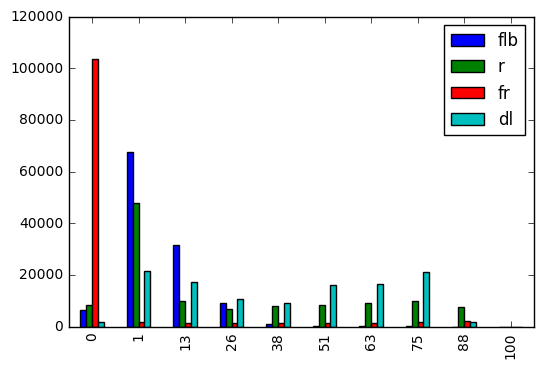

In [82]:
df = pd.DataFrame()
target = wrDisabled
df['flb'] = aggregateHist(target.filter(lambda p: p['content_paint_phase']),
              lambda p: p['content_paint_phase']['flb']['values'])
df['r'] = aggregateHist(target.filter(lambda p: p['content_paint_phase']),
              lambda p: p['content_paint_phase']['r']['values'])
df['fr'] = aggregateHist(target.filter(lambda p: p['content_paint_phase']),
              lambda p: p['content_paint_phase']['fr']['values'])
df['dl'] = aggregateHist(target.filter(lambda p: p['content_paint_phase']),
              lambda p: p['content_paint_phase']['dl']['values'])
df.plot(kind='bar')

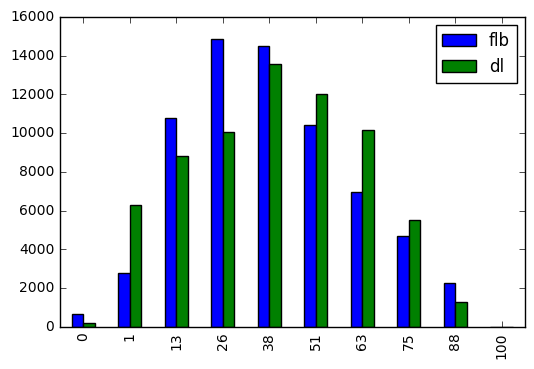

In [84]:
df = pd.DataFrame()
target = wrEnabled
df['flb'] = aggregateHist(target.filter(lambda p: p['content_paint_phase']),
              lambda p: p['content_paint_phase']['flb']['values'])
df['dl'] = aggregateHist(target.filter(lambda p: p['content_paint_phase']),
              lambda p: p['content_paint_phase']['dl']['values'])
df.plot(kind='bar')

In [68]:


    

aggregated_enabled = (wrDisabled
 .filter(lambda p: p['content_paint_phase'])
 .map(lambda p: p['content_paint_phase'])
 .map(lambda p: p['flb']['values'])
 .map(lambda p: pd.Series(p))
 .reduce(aggregate_series)
 #.map(lambda p: [sum(v["values"].values()) for k, v in p.items()])
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()
aggregated_enabled

0       6421.0
1      67671.0
13     31523.0
26      9367.0
38      1228.0
51       300.0
63       187.0
75       164.0
88        71.0
100        0.0
dtype: float64

In [30]:
control.count()/(treatment.count()*1.)

0.6519803675379523

In [31]:
treatment1 = treatment.sample(False, control.count()/(treatment.count()*1.0))
treatment2 = treatment.sample(False, control.count()/(treatment.count()*1.0))
treatment3 = treatment.sample(False, control.count()/(treatment.count()*1.0))
(control1,control2) = control.randomSplit([0.5, 0.5])
ratio = control.count()/(treatment.count()*1.)
(treatment1,treatment2,treatment3, treatment4) = treatment.randomSplit([ratio*.5,ratio*.5, ratio*.5, 1-ratio*.5*3])
[ratio*.5,ratio*.5, ratio*.5, 1-ratio*.5*3]




[0.32599018376897615,
 0.32599018376897615,
 0.32599018376897615,
 0.02202944869307155]

In [32]:
treatment.count(), treatment1.count(), treatment2.count(), treatment3.count(),  control1.count(), control2.count()

(8761, 2807, 2901, 2869, 2884, 2828)

In [28]:
wrQualified.map(lambda p: p['buildId']).countByValue()

defaultdict(int,
            {u'20180721220720': 1,
             u'20180722100230': 5,
             u'20180722220044': 1,
             u'20180723100101': 3,
             u'20180723220051': 3,
             u'20180724100052': 2,
             u'20180724223402': 1,
             u'20180725103029': 6,
             u'20180726001822': 3,
             u'20180726100339': 3,
             u'20180726220124': 3,
             u'20180727103347': 4,
             u'20180727231224': 2,
             u'20180728101501': 2,
             u'20180728220145': 4,
             u'20180729100102': 2,
             u'20180729220222': 4,
             u'20180730100211': 6,
             u'20180730221422': 8,
             u'20180731105217': 5,
             u'20180731220208': 12,
             u'20180801100116': 8,
             u'20180801223951': 9,
             u'20180802100128': 15,
             u'20180802220056': 20,
             u'20180803104322': 16,
             u'20180803220259': 41,
             u'20180804124335': 4

In [50]:
normandy = treatment.filter(lambda p: p['buildId'] == '20180731105217')
treatment.map(lambda p: p["gfx"]["features"]["compositor"]).countByValue()
#normandy.count()
#normandy.map(lambda p: p["adapter"]["deviceID"]).countByValue()
#normandy.filter(lambda p: p["gfx"]["features"]["compositor"] == "webrender").take(4)


defaultdict(int, {u'basic': 64, u'd3d11': 1034, u'webrender': 637})

Let's group the startup timings by OS:

In [ ]:
grouped = (
    cached
    .map(lambda p: (p['osName'], p['firstPaint']))
    .groupByKey()
    .collectAsMap()
)

And finally plot the data:

In [ ]:
frame = pd.DataFrame({x: np.log10(pd.Series(list(y))) for x, y in grouped.items()})
plt.figure(figsize=(17, 7))
frame.boxplot(return_type='axes')
plt.ylabel('log10(firstPaint)')
plt.show()

In [ ]:
plt.title('startup distribution for Windows')
plt.ylabel('count')
plt.xlabel('log10(firstPaint)')
frame['Windows_NT'].plot(kind='hist', bins=50, figsize=(14, 7))

### Histograms

Let's extract a histogram of GC_MARK_MS (time spent running JS garbage collection mark phase) from the submissions:

(see https://developer.mozilla.org/en-US/docs/Web/JavaScript/Memory_Management for more information)

In [ ]:
histograms = (
    pings_dataset
    .select(GC_MARK_MS_content='payload.processes.content.histograms.GC_MARK_MS.values',
            GC_MARK_MS_parent='payload.histograms.GC_MARK_MS.values')
    .records(sc, sample=0.05)
)

- `payload.histograms.GC_MARK_MS.values` is a path to the GC_MARK_MS values of the parent (main) process
- `payload.processes.content.histograms.GC_MARK_MS.values` is a path to the GC_MARK_MS values of the child processes

Let's aggregate the histogram over all submissions and plot it as a histogram.  Since the parent and child processes are recorded separately, we can create a histogram for each one and then add them together.

Each histogram is a pandas series where the index is the bucket and the value is the count.

In [34]:
def aggregate_series(s1, s2):
    """Function to sum up series; if one is None, return other"""
    if s1 is None:
        return s2
    if s2 is None:
        return s1
    return s1.add(s2, fill_value=0)

In [39]:
aggregated_enabled = (
    treatment1
    .map(lambda p: pd.Series(p['content_paint']))
    .reduce(aggregate_series)
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()

aggregated_disabled = (
    control1
    .map(lambda p: pd.Series(p['content_paint']))
    .reduce(aggregate_series)
)
aggregated_disabled.index = [int(i) for i in aggregated_disabled.index]
aggregated_disabled = aggregated_disabled.sort_index()

In [88]:
aggregated_disabled.sum()

14608178.0

In [89]:
aggregated_enabled.sum()

13402149.0

In [90]:
aggregated_disabled.loc[0:7].sum()/aggregated_disabled.sum()

0.9505665935888787

In [91]:
aggregated_enabled.loc[0:7].sum()/aggregated_enabled.sum()

0.9224537796140007

In [92]:
aggregated_disabled.loc[16].sum()/aggregated_disabled.loc[16:].sum()


0.32160110420979987

In [93]:
aggregated_enabled.loc[16].sum()/aggregated_enabled.loc[16:].sum()


0.33562027031006153

In [94]:
aggregated_enabled[22:].sum()

3710.0

In [95]:
aggregated_disabled[22:].sum()

5287.0

In [43]:
aggregated_disabled.sum(), aggregated_enabled.sum()


(85764050.0, 93993025.0)

In [51]:
aggregated_disabled[18:].sum(), aggregated_enabled[18:].sum()


(189655.0, 347631.0)

In [61]:
aggregated_enabled[20:].sum()/aggregated_enabled[0:].sum()

0.0017410121655303677

In [62]:
aggregated_disabled[20:].sum()/aggregated_disabled[0:].sum()

0.0012687600457301166

In [1]:
percent_enabled = aggregated_enabled[20:].map(lambda x: x/aggregated_enabled[0:].sum())
percent_disabled = aggregated_disabled[20:].map(lambda x: x/aggregated_disabled[0:].sum())
#percent_enabled = aggregated_enabled[23:]
#percent_disabled = aggregated_disabled[23:]

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("percentage of content paints that happen in less than x ms")


NameError: name 'aggregated_enabled' is not defined

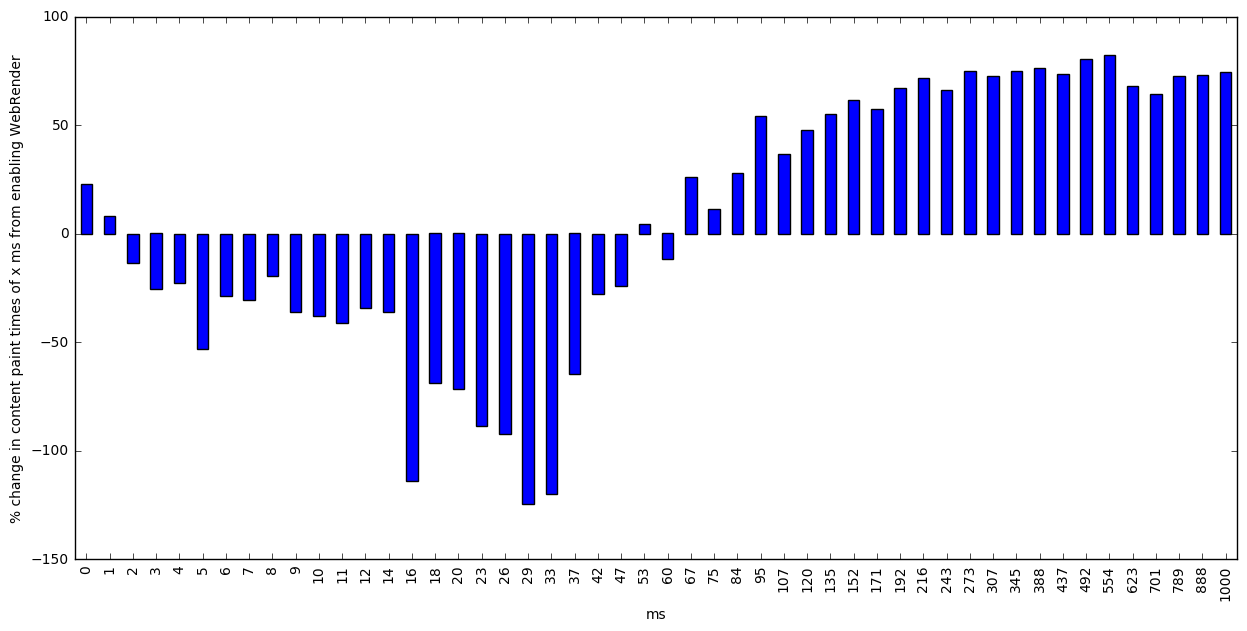

In [53]:
p = (100*(percent_disabled - percent_enabled)/percent_disabled).plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("% change in content paint times of x ms from enabling WebRender")

In [40]:
tab_aggregated_enabled = (
    treatment1
    .map(lambda p: pd.Series(p['tab_switch']))
    .reduce(aggregate_series)
)
tab_aggregated_enabled.index = [int(i) for i in tab_aggregated_enabled.index]
tab_aggregated_enabled = tab_aggregated_enabled.sort_index()

tab_aggregated_disabled = (
    control1
    .map(lambda p: pd.Series(p['tab_switch']))
    .reduce(aggregate_series)
)
tab_aggregated_disabled.index = [int(i) for i in tab_aggregated_disabled.index]
tab_aggregated_disabled = tab_aggregated_disabled.sort_index()

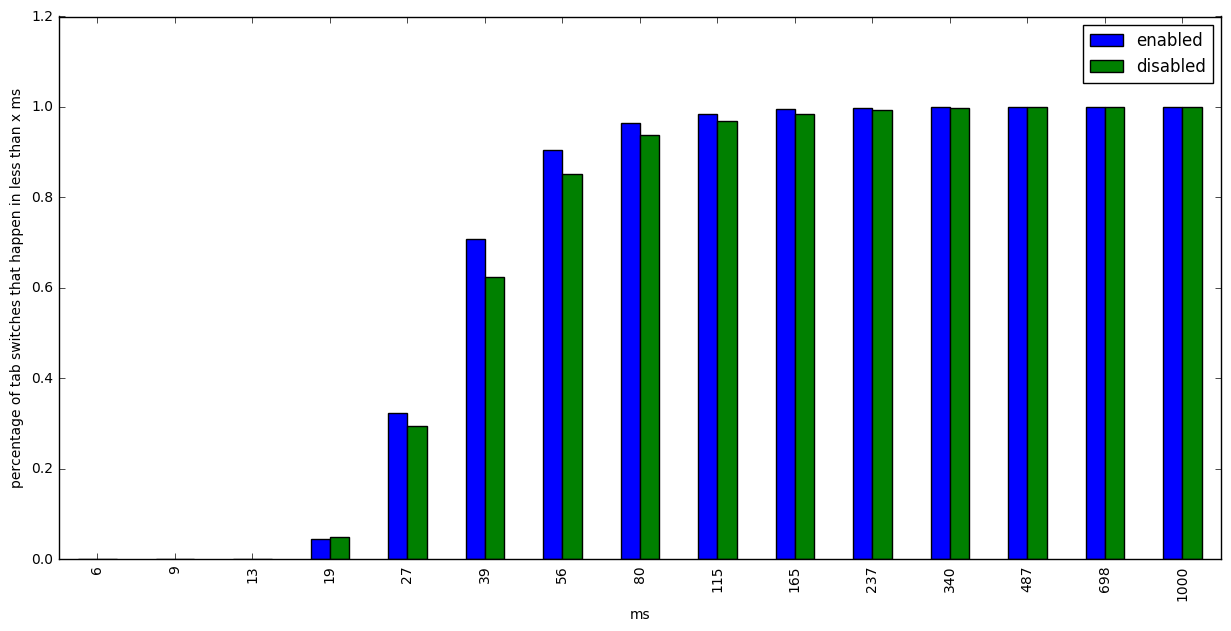

In [39]:
percent_enabled = tab_aggregated_enabled[0:].map(lambda x: x/tab_aggregated_enabled[0:].sum())
percent_disabled = tab_aggregated_disabled[0:].map(lambda x: x/tab_aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.cumsum().plot(kind='bar', figsize=(15, 7))
p.set_ylabel("percentage of tab switches that happen in less than x ms")
p.set_xlabel("ms")
#df

In [82]:
percent_enabled = tab_aggregated_enabled[:2].map(lambda x: x/tab_aggregated_enabled[0:].sum())
percent_disabled = tab_aggregated_disabled[1:3].map(lambda x: x/tab_aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
df

,enabled,disabled
6,0.000000,0.000013
9,0.000057,0.000000


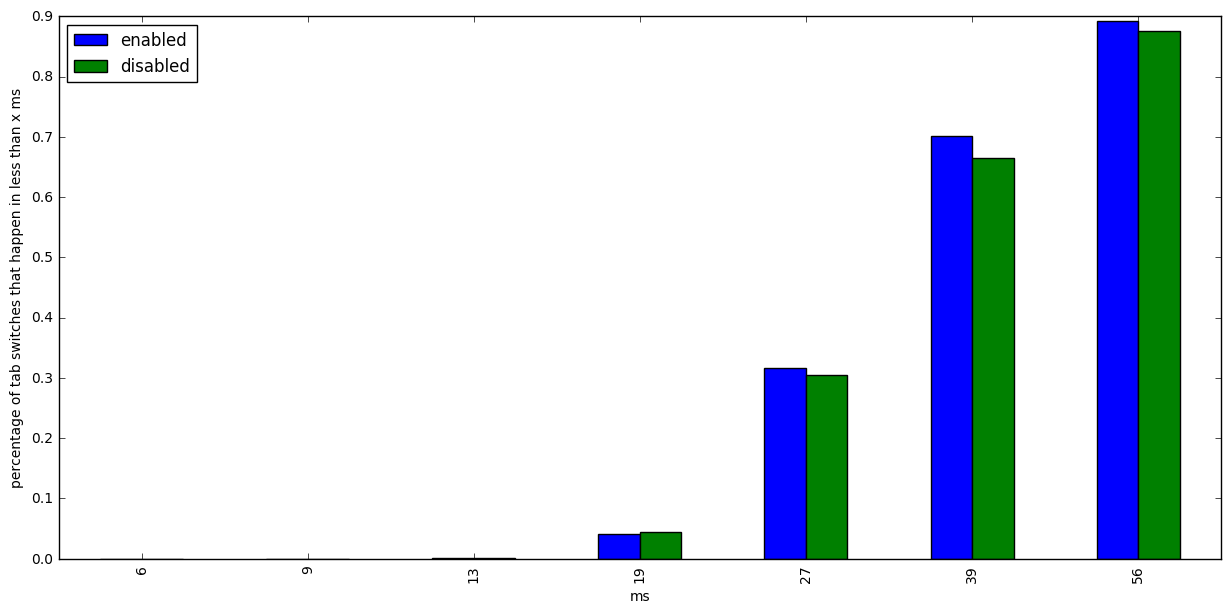

In [96]:
percent_enabled = tab_aggregated_enabled[:7].map(lambda x: x/tab_aggregated_enabled[0:].sum())
percent_disabled = tab_aggregated_disabled[1:8].map(lambda x: x/tab_aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.cumsum().plot(kind='bar', figsize=(15, 7))
p.set_ylabel("percentage of tab switches that happen in less than x ms")
p.set_xlabel("ms")
#df

In [94]:
tab_aggregated_enabled[6:].sum()/tab_aggregated_enabled[0:].sum()

0.2990898925705227

In [95]:
tab_aggregated_disabled[7:].sum()/tab_aggregated_disabled[0:].sum()

0.3348200748003639

In [93]:
0.7/0.6

1.1666666666666667

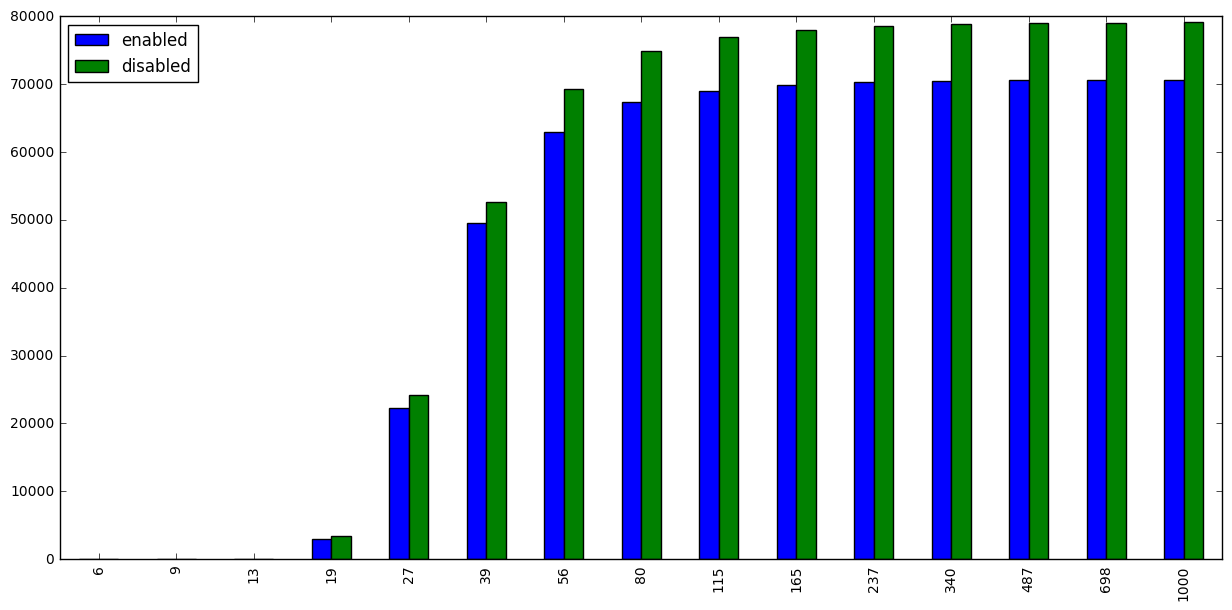

In [37]:
percent_enabled = tab_aggregated_enabled[0:]
percent_disabled = tab_aggregated_disabled[0:]

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.cumsum().plot(kind='bar', figsize=(15, 7))
#df

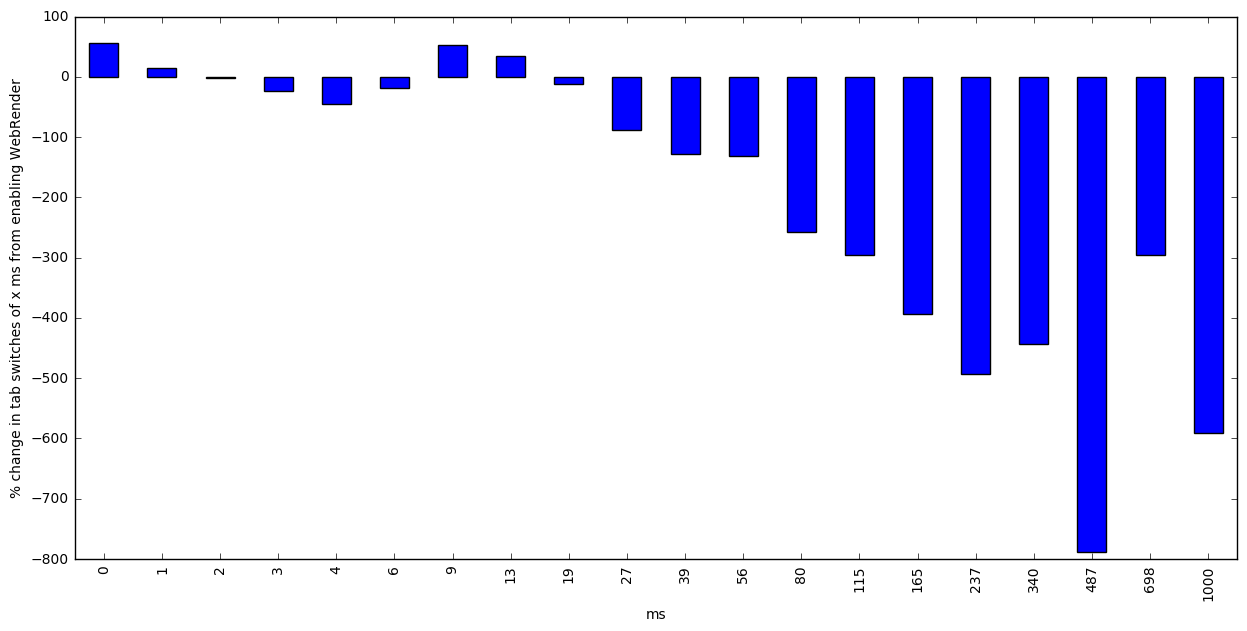

In [46]:
p = (100*(percent_enabled - percent_disabled) / percent_enabled).plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("% change in tab switches of x ms from enabling WebRender")

In [ ]:
plt.title('wr_enabled')
precent_enabled.plot(kind='bar', figsize=(15, 7))

In [ ]:
plt.title('wr_disabled')
aggregated_disabled.plot(kind='bar', figsize=(15, 7))
aggregated_enabledd.plot(kind='bar', figs)

In [36]:
check_aggregated_enabled = (
    treatment1
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_enabled.index = [int(i) for i in check_aggregated_enabled.index]
check_aggregated_enabled = check_aggregated_enabled.sort_index()

check_aggregated_disabled = (
    control1
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled.index = [int(i) for i in check_aggregated_disabled.index]
check_aggregated_disabled = check_aggregated_disabled.sort_index()

check_aggregated_disabled2 = (
    treatment2
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled2.index = [int(i) for i in check_aggregated_disabled2.index]
check_aggregated_disabled2 = check_aggregated_disabled2.sort_index()

check_aggregated_disabled3 = (
    treatment3
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled3.index = [int(i) for i in check_aggregated_disabled3.index]
check_aggregated_disabled3 = check_aggregated_disabled3.sort_index()

check_aggregated_disabled4 = (
    control2
    .map(lambda p: pd.Series(p['checkerboardin']))
    .reduce(aggregate_series)
)
check_aggregated_disabled4.index = [int(i) for i in check_aggregated_disabled4.index]
check_aggregated_disabled4 = check_aggregated_disabled4.sort_index()

,enabled,enabled2,enabled3,disabled,disabled2
0,191.0,169.0,234.0,173.0,202.0
1,2.0,13.0,1.0,2.0,1.0
2,4.0,6.0,6.0,3.0,2.0
3,16.0,13.0,9.0,7.0,7.0
5,7.0,10.0,15.0,9.0,15.0
8,18.0,24.0,21.0,23.0,33.0
12,90.0,86.0,85.0,202.0,187.0
18,156.0,154.0,167.0,450.0,431.0
28,70.0,48.0,63.0,97.0,72.0
43,54.0,54.0,47.0,21.0,23.0


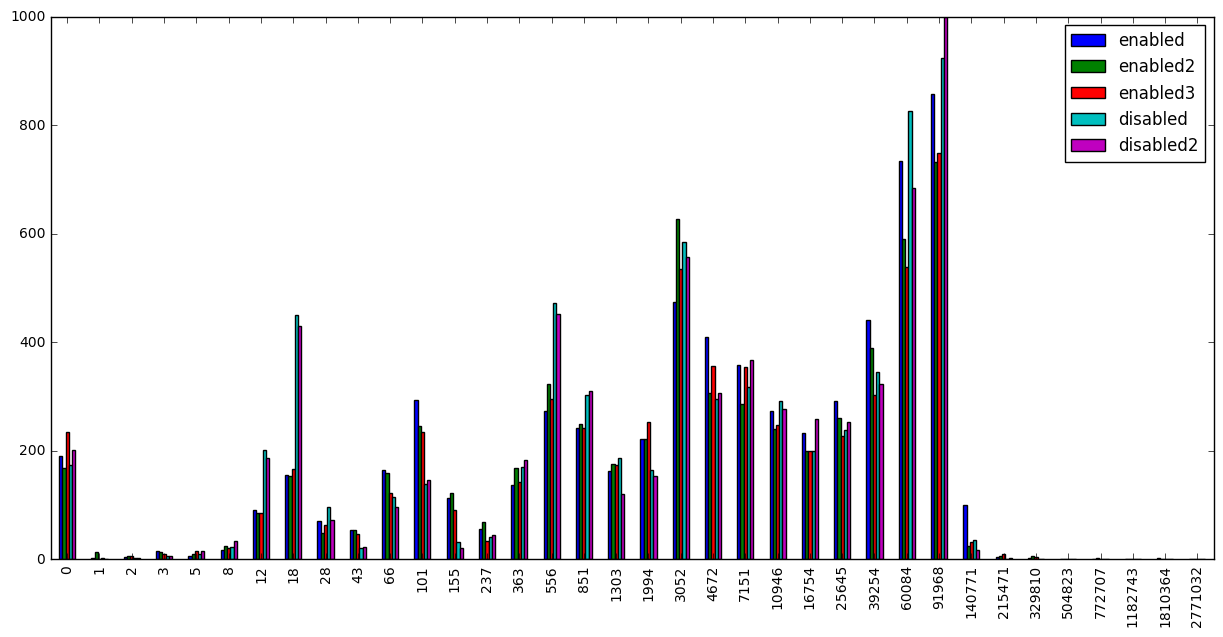

In [37]:
df = pd.DataFrame()
df['enabled'] = check_aggregated_enabled
df['enabled2'] = check_aggregated_disabled2
df['enabled3'] = check_aggregated_disabled3
df['disabled'] = check_aggregated_disabled
df['disabled2'] = check_aggregated_disabled4



#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
df.plot(kind='bar', figsize=(15, 7))
df

#df

In [82]:
def add_pair(x, y):
  if x[0] is None and y[0] is None:
    return (None, x[1]+y[1])
  return (x[0]+y[0], x[1]+y[1])

preserve = ["client_id", "branch", "compositor", "wrQualified", "wrStatus"]

def explode_user_agg(x):
  """Explodes our selected histograms from each ping into key-value pairs like
  [(client_id, probe_name), (sum_values, n_values)].
  
  For distributions, sum and n are meaningful. For counts, sum_values is 0 or None.
  """
  def key_for_label(label):
    return tuple([x[i] for i in preserve] + [label])
  
  rows = []
  for label, procs, method in histograms:
    key = key_for_label(label)
    value = (0, 0)
    for proc in procs:
      v_sum = x["{}/{}/{}".format(label, proc, "sum")] or 0
      # count the number of recorded events
      v_values = sum((x["{}/{}/{}".format(label, proc, "values")] or {0: 0}).values())
      value = add_pair(value, (v_sum, v_values))
    rows.append([key, value])
  
  for label, procs, method in keyedHistograms:
    key = key_for_label(label)
    for proc in procs:
      probe = x["{}/{}".format(label, proc)]
      if not probe:
        continue
      first_key = list(probe.values())[0]
      n_events = sum(first_key["values"].values())
      rows.append([key, (None, n_events)])

  return rows

def deaggregate(x):
  fields = {k: v for k, v in zip(preserve + ["probe"], x[0])}
  fields["sum_values"], fields["n_values"] = x[1]
  return Row(**fields)

per_user_key = (
  wrDisabled
  .flatMap(explode_user_agg)
  .reduceByKey(add_pair)
  .map(deaggregate)
)
per_user_key.take(1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 237.0 failed 4 times, most recent failure: Lost task 2.3 in stage 237.0 (TID 4527, ip-172-31-13-115.us-west-2.compute.internal, executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 177, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1842, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-82-6b9aeb4be8a3>", line 18, in explode_user_agg
NameError: global name 'histograms' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:404)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1708)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1696)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1695)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1695)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:855)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:855)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:855)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1867)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:671)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2029)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2050)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2069)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:455)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor219.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 177, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1842, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-82-6b9aeb4be8a3>", line 18, in explode_user_agg
NameError: global name 'histograms' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:404)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [115]:
wrDisabled.filter(lambda p: p['frame_time']).take(1)

[{'adapter': {u'GPUActive': True,
   u'RAM': 2048,
   u'description': u'NVIDIA GeForce GTX 660',
   u'deviceID': u'0x11c0',
   u'driver': u'C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumdx.dll C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll,C:\\WINDOWS\\System32\\DriverStore\\FileRepository\\nv_dispi.inf_amd64_38c9bee769f9ef1f\\nvldumd.dll',
   u'driverDate': u'5-7-2018',
   u'driverVers

In [ ]:
int(5) < 100

In [48]:
from collections import Counter

In [89]:
def roundDict(x):
    int_x = {int(k) : v for k, v in x.items()}
    d = {}
    lastValue = 0
    for (key, value) in sorted(int_x.iteritems()):
        if key < 100:
            lastValue = value
            continue
        rounded = key/100
        if rounded in d:
            d[rounded] += lastValue
        else:
            d[rounded] = lastValue
        lastValue = value
    return d
def sumHist(x):
    s = 0
    for (key, value) in x.iteritems():
        s += key * value
    return s
def countHist(x):
    s = 0
    for (key, value) in x.iteritems():
        s += value
    return s

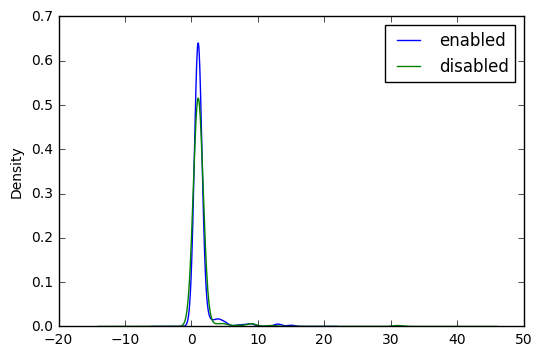

In [90]:
#means = (
#    wrEnabled.filter(lambda p: p['frame_time']).map(lambda p: p['frame_time_sum']/sum(p['frame_time'].values()))
#    .filter(lambda p: p< 1000)
#)
means = (wrEnabled.filter(lambda p: p['frame_time']).map(lambda p: roundDict(p['frame_time']))
         .filter(lambda p: countHist(p) != 0)
         .map(lambda p: sumHist(p)/countHist(p))
        )
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df = pd.DataFrame()
df['enabled'] = means
means = (wrDisabled.filter(lambda p: p['frame_time']).map(lambda p: roundDict(p['frame_time']))
         .filter(lambda p: countHist(p) != 0)
         .map(lambda p: sumHist(p)/countHist(p))
        )
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df['disabled'] = means
df.plot.density()#means.take(4)

In [91]:
aggregated_enabled = (
    wrEnabled
    .filter(lambda p: p['frame_time'])
    .map(lambda p: pd.Series(roundDict(p['frame_time'])))
    .reduce(aggregate_series)
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()

aggregated_disabled = (
    wrDisabled2
    .filter(lambda p: p['frame_time'])
    .map(lambda p: pd.Series(roundDict(p['frame_time'])))
    .reduce(aggregate_series)
)
aggregated_disabled.index = [int(i) for i in aggregated_disabled.index]
aggregated_disabled = aggregated_disabled.sort_index()

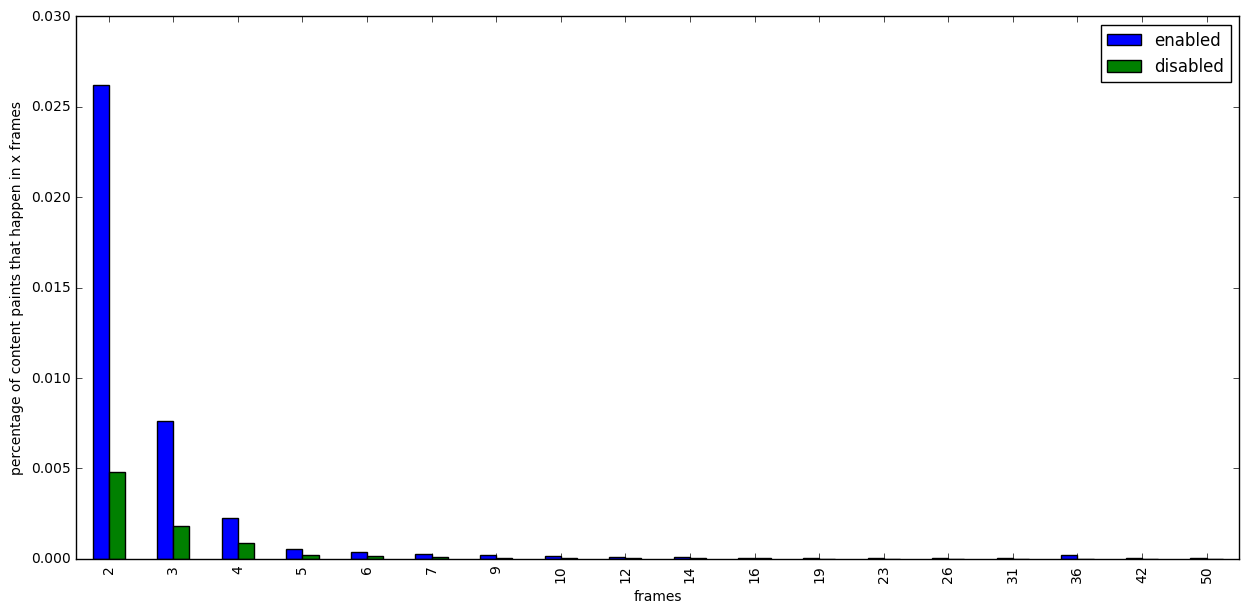

In [108]:
percent_enabled = aggregated_enabled[1:].map(lambda x: x/aggregated_enabled[0:].sum())
percent_disabled = aggregated_disabled[1:].map(lambda x: x/aggregated_disabled[0:].sum())

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.plot(kind='bar', figsize=(15, 7))
p.set_xlabel("frames")
p.set_ylabel("percentage of content paints that happen in x frames")

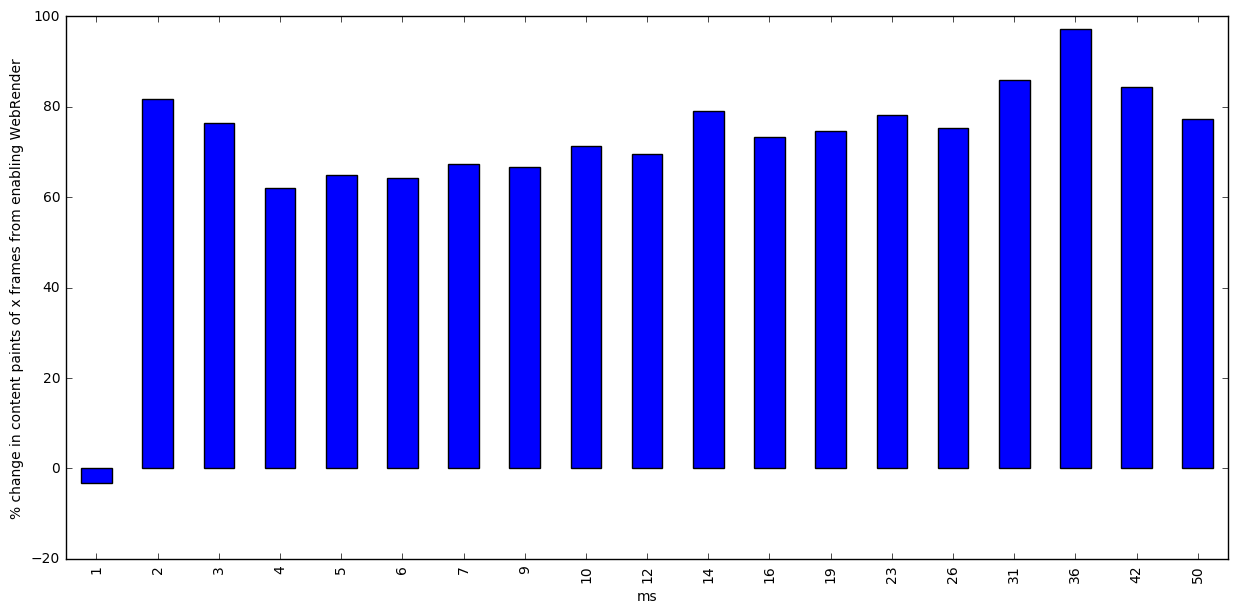

In [106]:
p = (100*(percent_enabled - percent_disabled) / percent_enabled).plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("% change in content paints of x frames from enabling WebRender")

In [47]:
means = (
    wrDisabled.filter(lambda p: p['composite_time']).map(lambda p: p['composite_time']['sum']/sum(p['composite_time']['values'].values()))
    .filter(lambda p: p< 1000)
)
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
means

,_1
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


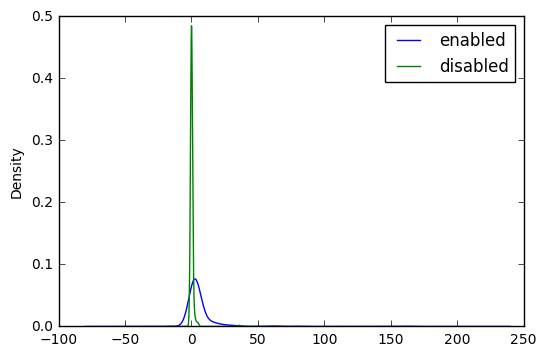

In [48]:
means = (
    wrEnabled.filter(lambda p: p['composite_time']).map(lambda p: p['composite_time']['sum']/sum(p['composite_time']['values'].values()))
    .filter(lambda p: p< 1000)
)
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df = pd.DataFrame()
df['enabled'] = means
means = (
    wrDisabled.filter(lambda p: p['composite_time']).map(lambda p: p['composite_time']['sum']/sum(p['composite_time']['values'].values()))
    .filter(lambda p: p< 1000)
)
means = means.map(lambda x: (x, )).toDF()
means = means.toPandas()
df['disabled'] = means
df.plot.density()#means.take(4)

In [61]:
aggregated_enabled = (
    wrEnabled
    .filter(lambda p: p['composite_time'])
    .map(lambda p: pd.Series(p['composite_time']['values']))
    .reduce(aggregate_series)
)
aggregated_enabled.index = [int(i) for i in aggregated_enabled.index]
aggregated_enabled = aggregated_enabled.sort_index()

aggregated_disabled = (
    wrDisabled2
    .filter(lambda p: p['composite_time'])
    .map(lambda p: pd.Series(p['composite_time']['values']))
    .reduce(aggregate_series)
)
aggregated_disabled.index = [int(i) for i in aggregated_disabled.index]
aggregated_disabled = aggregated_disabled.sort_index()

(59394031.0, 87039907.0, 284, 271)

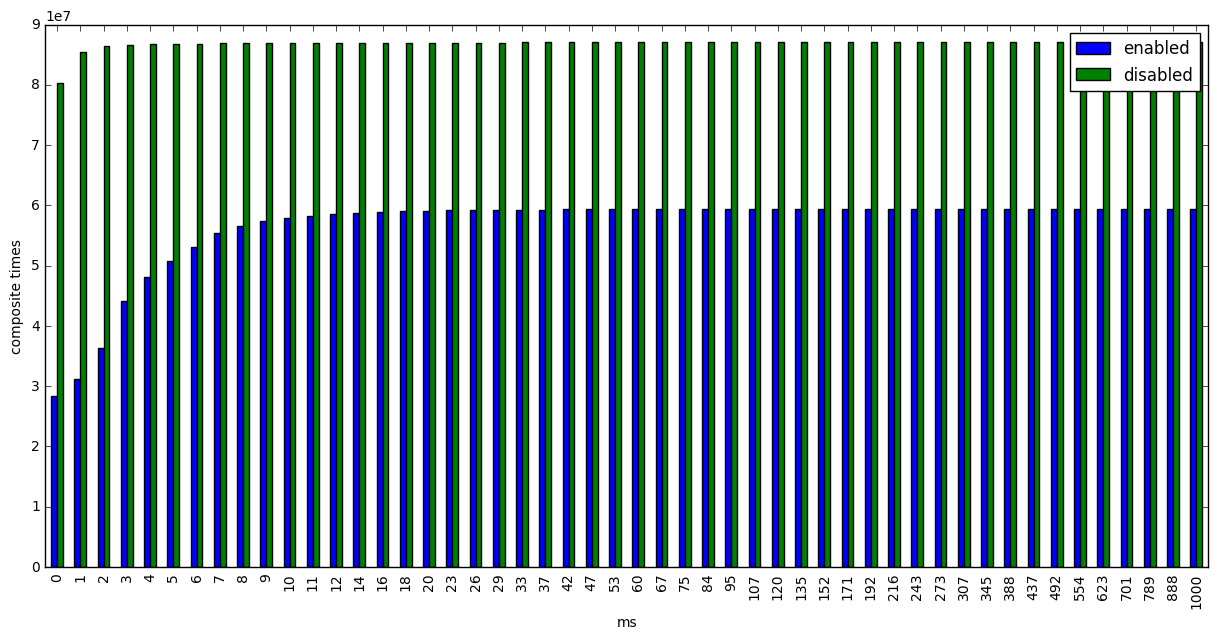

In [62]:
percent_enabled = aggregated_enabled
percent_disabled = aggregated_disabled

percent = percent_enabled
df = pd.DataFrame()
df['enabled'] = percent_enabled
df['disabled'] = percent_disabled
#(percent_enabled - percent_disabled).plot(kind='bar', figsize=(15, 7))
p = df.cumsum().plot(kind='bar', figsize=(15, 7))
p.set_xlabel("ms")
p.set_ylabel("composite times")
(aggregated_enabled.sum(), aggregated_disabled.sum(), wrEnabled.count(), wrDisabled.count())

We can also aggregate the values of the parent and children processes:

In [ ]:
plt.title('GC_MARK_MS')
(aggregated_content + aggregated_parent).plot(kind='bar', figsize=(15, 7))

Keyed histograms follow a similar pattern. To extract a keyed histogram for which we know the key/label we are interested in:

In [ ]:
keyed_hist = (
    pings_dataset
    .select(redirects='payload.keyedHistograms.NETWORK_HTTP_REDIRECT_TO_SCHEME.https.values')
    .records(sc, sample=0.05)
)

Add up the counts of every ping and plot it:

In [ ]:
aggregated = (
    keyed_hist
    .filter(lambda p: p['redirects'] is not None)
    .map(lambda p: pd.Series(p['redirects']))
    .reduce(lambda c1, c2: c1 + c2)
)

In [ ]:
aggregated.plot(kind='bar', figsize=(15, 7))